<a href="https://colab.research.google.com/github/SSPedersen/VAE-and-LVAE-Super-Resolution/blob/main/CNN_SR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn  import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, ConvTranspose2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [ ]:
 import os
 import pickle

 import numpy as np
 from torch.utils.data import Dataset
 from PIL import Image
 from torch.utils.data import Dataset
 from PIL import Image
 from skimage.transform import resize
 import torchvision.transforms as transforms
 from torchvision.datasets import CIFAR10, Flickr8k
 from sklearn.model_selection import train_test_split
 from torch.utils.data import Subset
 from torch.utils.data import DataLoader


# #def load_pickled_data(fname):
#  #   with open(fname, 'rb') as f:
#   #      data = pickle.load(f)

#    # train_data, test_data = data['train'], data['test']
#  #   train_data = train_data[:, :, :, [2, 1, 0]]
#   #  test_data = test_data[:, :, :, [2, 1, 0]]
#   #  return train_data, test_data

# class MiniCeleba(Dataset):
#     """Celeba dataset"""

#     def __init__(self, data, transform=None):
#         h, w, c = 32, 32, 3

#         # binarize data
#         data = data > 1

#         self.data = np.ascontiguousarray(data.reshape(-1, h, w, 3), dtype=np.float32)
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         sample = self.data[idx]

#         sample = Image.fromarray(255 * sample)  # cannot read bytes directly: https://github.com/numpy/numpy/issues/5861

#         if self.transform:
#             sample = self.transform(sample)

#         return sample


# def get_mini_celeba(transform=None):
#     """credits to https://github.com/rll/deepul"""
#     data_dir = '/content/data/'
#     train_data, test_data = load_pickled_data(os.path.join(data_dir, 'celeb.pkl'))
#     dset_train = MiniCeleba(train_data, transform=transform)
#     dset_test = MiniCeleba(test_data, transform=transform)
#     return dset_train, dset_test, dset_test


# dset_train, dset_valid, dset_test = get_mini_celeba()

# loader_train = DataLoader(dset_train, batch_size=1, num_workers=2)
# loader_valid = DataLoader(dset_valid, batch_size=1, num_workers=2)
# loader_test = DataLoader(dset_test, batch_size=1, num_workers=2)

# train_iter=iter(loader_train)
# valid_iter=iter(loader_valid)
# test_iter=iter(loader_test)

In [ ]:
h, w, c = 32, 32, 3
dh, dw, dc = 16, 16, 3

class CIFAR(Dataset):
    """CIFAR10 dataset"""

    def __init__(self, data, transform=None):

      self.data1 = np.ascontiguousarray(data.reshape(-1, h, w, c), dtype=np.float32)
      x = np.copy((data1))

      x = torch.tensor(x)
      print(f">> x : {x.shape}")
      x = transform.Resize((dc, dw, dh))
      print(f">>>> x : {x.shape}")

      self.downSampledData = x


      #self.downSampledData = np.ascontiguousarray(data.reshape(-1, dh, dw, c), dtype=np.float32)
      print("hej", data.shape)
      print("hej", self.data1.shape)
      #print("hej", self.downSampledData.shape)
      self.transform = transform

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      sample = self.data1[idx]
      downSample = self.downSampledData[idx]

      sample = Image.fromarray(255 * sample, mode= 'RGB') # cannot read bytes directly: https://github.com/numpy/numpy/issues/5861
      downSample = Image.fromarray(255 * downSample, mode= 'RGB') 

      if self.transform:
        downSample = self.transform(downSample)
      return sample, downSample



class CIFAR(CIFAR10):
    """CIFAR10 dataset"""

    def __init__(self, *args, **kwargs):
      super().__init__(*args, **kwargs)

      # resizing
      resize_fn = transforms.Resize((dh, dw))
      x = torch.tensor(self.data).permute(0, 3, 1, 2) # BHWC -> BCHW
      x = resize_fn(x).permute(0, 2, 3, 1) # BCHW -> BHWC

      self.downsampled_data = x.numpy()

    def __getitem__(self, idx):

      x,_ = super().__getitem__(idx)

      y = self.downsampled_data[idx]

      if self.transform is not None:
        y = self.transform(y)

      return x, y



dset = CIFAR(root='./data', train=True, download=True, transform=transforms.ToTensor())


def reduce_dataset(dataset, reduction):
    discarded_idx, reduced_idx = train_test_split(list(range(len(dataset))), test_size=reduction)
    reduced_dataset = Subset(dataset, reduced_idx)
    return reduced_dataset

def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


r_dataset = reduce_dataset(dset,0.01)

datasets = train_val_dataset(r_dataset)

train_set = datasets['train']
valid_set = datasets['val'] 

dloader = {x:DataLoader(datasets[x], 1, shuffle=True, num_workers=4) for x in ['train','val']}


train_data_iter = iter(dloader['train'])
val_data_iter = iter(dloader['val'])

Files already downloaded and verified


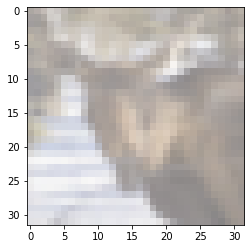

In [ ]:
# Run this cell multiple time to see more samples
def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
x,y = val_data_iter.next()


# show images
imshow(torchvision.utils.make_grid(x[0]))


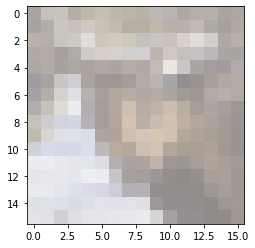

In [ ]:
imshow(torchvision.utils.make_grid(y[0]))

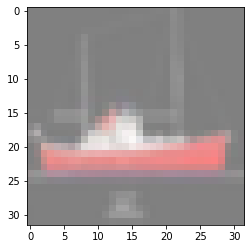

In [ ]:
x1,y1 = train_data_iter.next()
#imshow(torchvision.utils.make_grid(images1[0]))
imshow(torchvision.utils.make_grid(x1[0]))

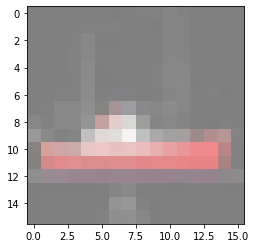

In [ ]:
imshow(torchvision.utils.make_grid(y1[0]))

In [ ]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [ ]:
# define SRCNN network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv2d(in_channels=3,
                             out_channels=256,
                             padding=2,
                             kernel_size=5)

        self.conv_2 = Conv2d(in_channels=256,
                             out_channels=128,
                             padding=1,
                             kernel_size=3)

        self.conv_3 = Conv2d(in_channels=128,
                             out_channels=3,
                             kernel_size=5)    

        self.upsample = nn.Upsample(scale_factor=1.5, mode='nearest');
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest');

    def forward(self, x):
        x = self.conv_1(x)
        x = relu(x)
        x = self.upsample(x)

        x = self.conv_2(x)
        x = relu(x)
        x = self.upsample(x)

        x = self.conv_3(x)

        return x


net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(128, 3, kernel_size=(5, 5), stride=(1, 1))
  (upsample): Upsample(scale_factor=1.5, mode=nearest)
  (upsample2): Upsample(scale_factor=2.0, mode=nearest)
)


In [ ]:
#Setting up Parameters

# The paper used MSE loss
criterion = nn.MSELoss()
# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
import math

In [ ]:
def train(net, dataloader,):
    net.train()
    running_loss = 0.0
    running_psnr = 0.0
    net.train()
    for i, data in enumerate(dataloader,0):
        # get the inputs
        target, input = data

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        input, target = input.to(device), target.to(device)

        # wrap them in Variable
        input, target = Variable(input), Variable(target)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(input)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # add loss
        running_loss += loss.item()

        # calculate psnr
        psnr = 10 * math.log10(1 / loss)
        
        running_psnr += psnr
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_set)/dataloader.batch_size)
    return final_loss, final_psnr

In [ ]:
def validate(net, dataloader):
    net.train()
    net.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader,0):
            # get the inputs
            target, input = data

            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            input, target = input.to(device), target.to(device)


            # wrap them in Variable
            input, target = Variable(input), Variable(target)
           
            outputs = net(input)
            loss = criterion(outputs, target)
            running_loss += loss.item()
            #if(i%10 == 0):
             # imshow(torchvision.utils.make_grid(outputs.to("cpu")))
            # calculate psnr
            psnr = 10 * math.log10(1 / loss)

            running_psnr += psnr
        outputs = outputs.cpu()
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_set)/dataloader.batch_size)
    return final_loss, final_psnr

Epoch 1 of 10


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid rang

Train PSNR: 22.262
Val PSNR: 9.351
Train loss: 0.007
Val loss: 0.007
Epoch 2 of 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train PSNR: 21.754
Val PSNR: 9.549
Train loss: 0.007
Val loss: 0.007
Epoch 3 of 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train PSNR: 22.307
Val PSNR: 9.583
Train loss: 0.007
Val loss: 0.007
Epoch 4 of 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train PSNR: 22.252
Val PSNR: 9.579
Train loss: 0.007
Val loss: 0.007
Epoch 5 of 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train PSNR: 21.943
Val PSNR: 9.078
Train loss: 0.007
Val loss: 0.008
Epoch 6 of 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train PSNR: 22.294
Val PSNR: 9.627
Train loss: 0.007
Val loss: 0.006
Epoch 7 of 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train PSNR: 22.628
Val PSNR: 9.674
Train loss: 0.006
Val loss: 0.006
Epoch 8 of 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Train PSNR: 22.631
Val PSNR: 8.881
Train loss: 0.006
Val loss: 0.009
Epoch 9 of 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train PSNR: 22.522
Val PSNR: 9.701
Train loss: 0.006
Val loss: 0.006
Epoch 10 of 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train PSNR: 22.549
Val PSNR: 9.578
Train loss: 0.006
Val loss: 0.007


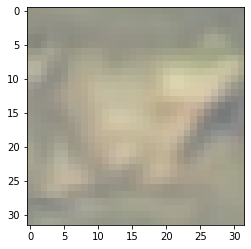

In [ ]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(net, dloader['train'])
    val_epoch_loss, val_epoch_psnr = validate(net, dloader['val'])
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    print(f"Train loss: {train_epoch_loss:.3f}")
    print(f"Val loss: {val_epoch_loss:.3f}")
